``` Lab Assignment - 5 ``` 


```Mrinal Bhan DSAI - 211020428```

## Task - A

### 1. Normalize the dataset with at least two type of normalization techniques.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Flatten the images for normalization
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))


scaler_minmax = MinMaxScaler()
train_images_minmax = scaler_minmax.fit_transform(train_images)
test_images_minmax = scaler_minmax.transform(test_images)


scaler_zscore = StandardScaler()
train_images_zscore = scaler_zscore.fit_transform(train_images)
test_images_zscore = scaler_zscore.transform(test_images)


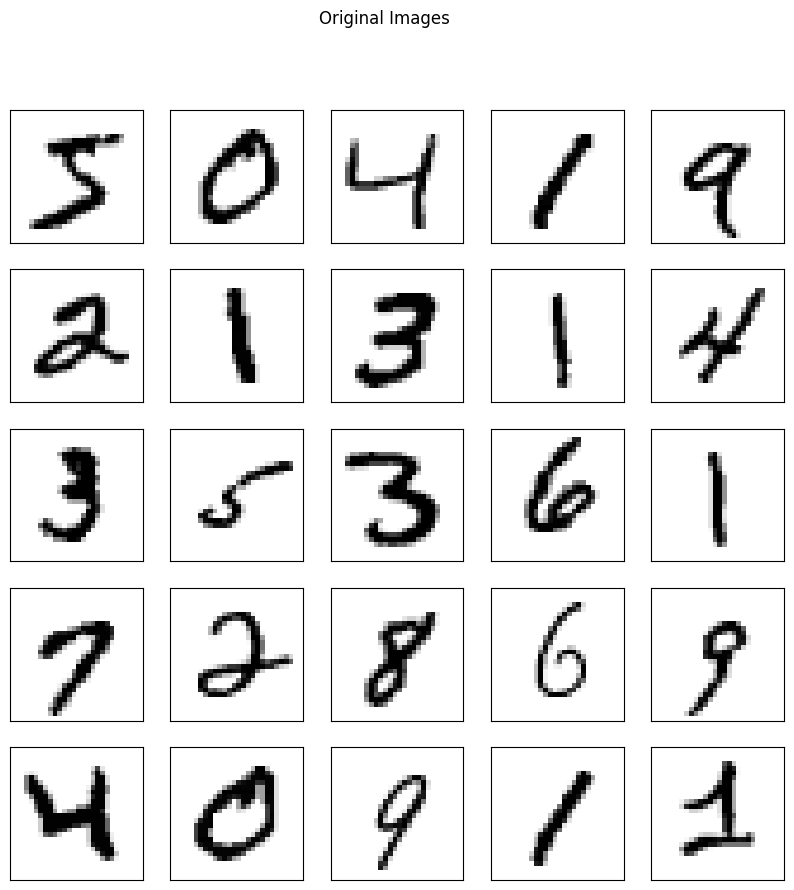

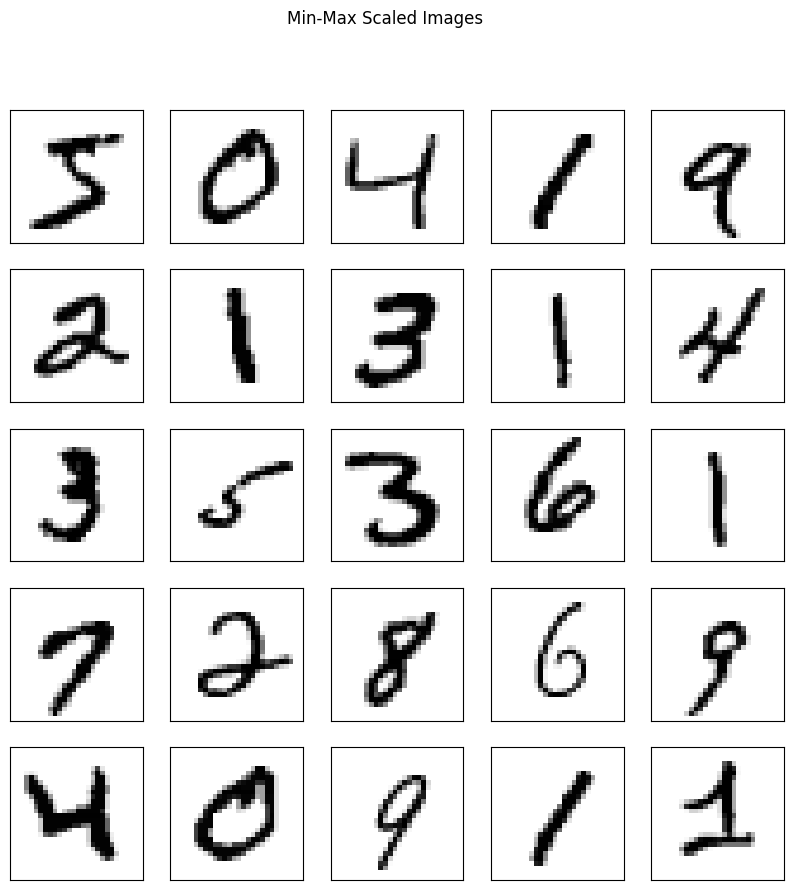

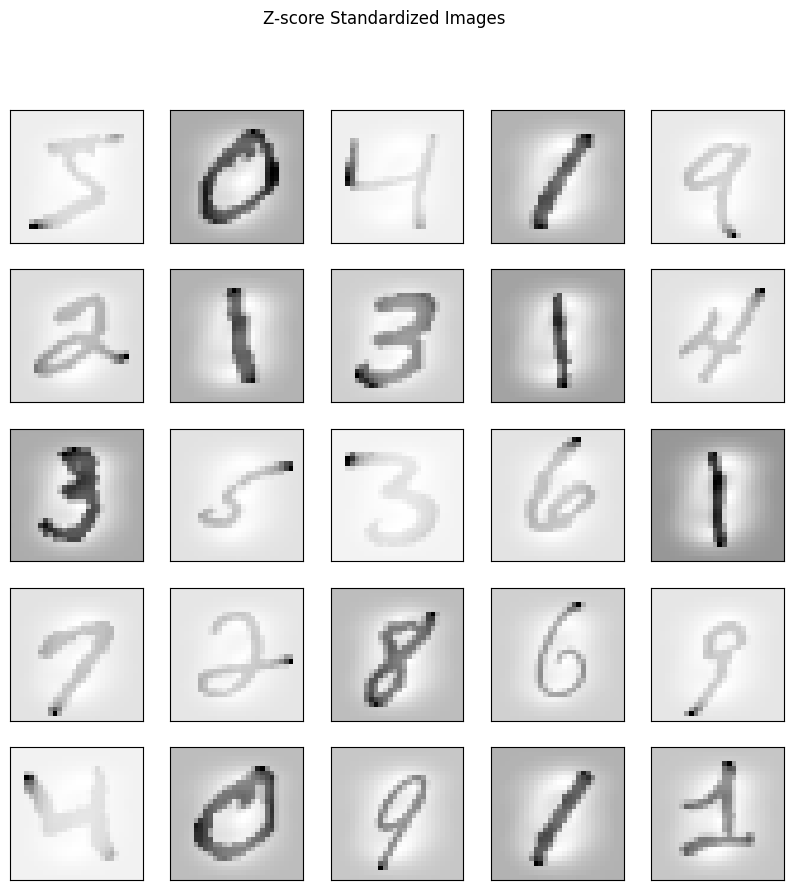

In [3]:
import matplotlib.pyplot as plt

def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.suptitle(title)
    plt.show()

display_images(train_images[:25], title="Original Images")
display_images(train_images_minmax[:25], title="Min-Max Scaled Images")
display_images(train_images_zscore[:25], title="Z-score Standardized Images")


### 2. Create a neural network architecture based auto encoder to classification of data. Typically,it consists of an encoder and a decoder.

In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models


# Define an autoencoder architecture
def create_autoencoder(input_shape, encoding_dim):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    encoder = layers.Flatten()(encoder_input)
    encoder = layers.Dense(512, activation='relu')(encoder)
    encoder = layers.Dense(256, activation='relu')(encoder)
    encoder_output = layers.Dense(encoding_dim, activation='relu')(encoder)

    # Decoder
    decoder_input = layers.Input(shape=(encoding_dim,))
    decoder = layers.Dense(256, activation='relu')(decoder_input)
    decoder = layers.Dense(512, activation='relu')(decoder)
    decoder = layers.Dense(np.prod(input_shape), activation='sigmoid')(decoder)
    decoder_output = layers.Reshape(input_shape)(decoder)

    # Create the encoder and decoder models
    encoder_model = models.Model(encoder_input, encoder_output, name='encoder')
    decoder_model = models.Model(decoder_input, decoder_output, name='decoder')

    # Create the autoencoder model by chaining encoder and decoder
    autoencoder_input = layers.Input(shape=input_shape)
    autoencoder_output = decoder_model(encoder_model(autoencoder_input))
    autoencoder_model = models.Model(autoencoder_input, autoencoder_output, name='autoencoder')

    return encoder_model, autoencoder_model

# Define constants
input_shape = train_images_minmax[0].shape  # Shape of input data
encoding_dim = 128  # Dimension of the encoded representation

# Create the autoencoder and encoder models
encoder_model, autoencoder_model = create_autoencoder(input_shape, encoding_dim)
test_images_minmax

# Compile the autoencoder model
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder_model.fit(train_images_minmax, train_images_minmax, epochs=10, batch_size=128, shuffle=True, validation_data=(test_images_minmax, test_images_minmax))

# Use encoder for classification
encoded_train_data = encoder_model.predict(train_images_minmax)
encoded_test_data = encoder_model.predict(test_images_minmax)

# Define a classification model (e.g., a simple feedforward network)
classifier = models.Sequential([
    layers.Input(shape=(encoding_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(100, activation='softmax')  # 100 classes for CIFAR-100
])

# Compile the classifier
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
classifier.fit(encoded_train_data, train_labels, epochs=10, batch_size=128, shuffle=True, validation_data=(encoded_test_data, test_labels))

# Evaluate the classifier test_labels
test_loss, test_accuracy = classifier.evaluate(encoded_test_data, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10
469/469 [==============================] - 10s 20ms/step - loss: 0.0311 - val_loss: 0.0143
Epoch 2/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 3/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 5/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 6/10
469/469 [==============================] - 10s 20ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 7/10
469/469 [==============================] - 9s 20ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 8/10
469/469 [==============================] - 12s 25ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 9/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 10/10
313/313 [==============================] - 1s 2ms/step
Epoch 1/10
469/469

1/1 [==============================] - 0s 69ms/step


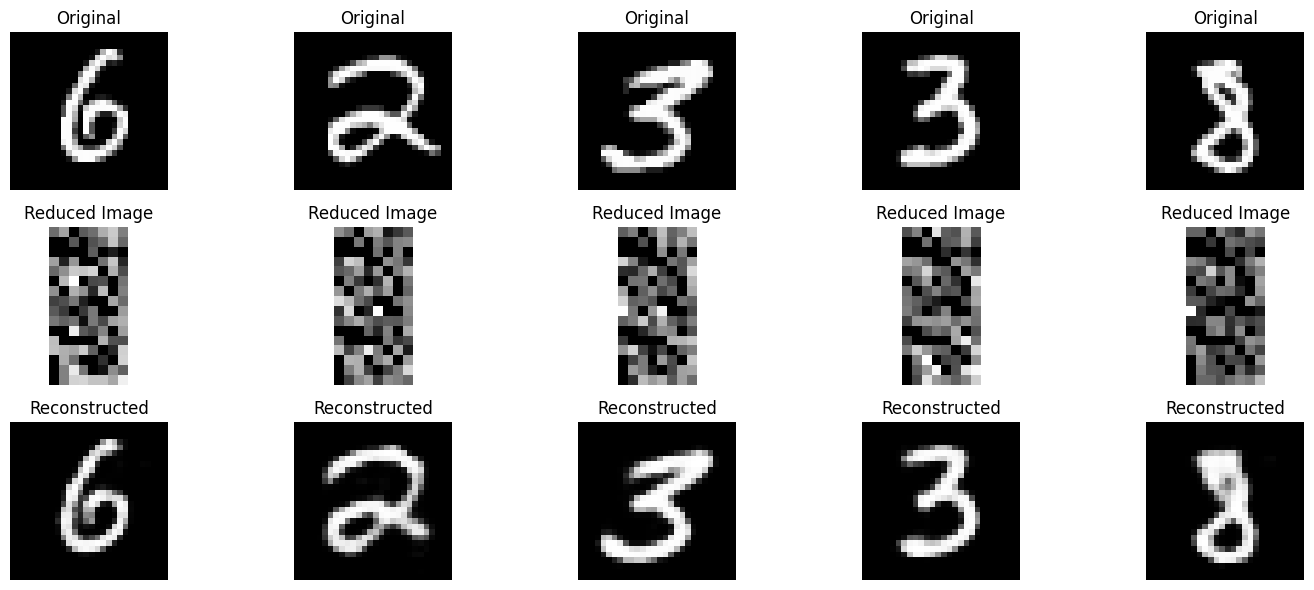

In [42]:
import matplotlib.pyplot as plt

# Display a few original, reduced shape, and reconstructed images
n = 5  # Number of images to display

# Select random images from the test set
random_indices = np.random.randint(0, len(test_images_minmax), n)
selected_original_images = test_images_minmax[random_indices]
selected_encoded_images = encoder_model.predict(selected_original_images)
selected_reconstructed_images = autoencoder_model.predict(selected_original_images)

# Create a figure to display the images
plt.figure(figsize=(15, 6))

for i in range(n):
    # Original Images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(selected_original_images[i].reshape(28, 28), cmap='gray')  # Reshape to (28, 28)
    plt.title("Original")
    plt.axis('off')

    # Reduced Images
    ax = plt.subplot(3, n, i + 1 + n)
    reduced_image = selected_encoded_images[i].reshape(16, 8)  # Assuming encoding_dim is 128
    plt.imshow(reduced_image, cmap='gray')
    plt.title("Reduced Image")
    plt.axis('off')

    # Reconstructed Images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(selected_reconstructed_images[i].reshape(28, 28), cmap='gray')  # Reshape to (28, 28)
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Task - B

### 1. Perform auto encoder where the encoder reduces the input data dimensions, and the decoder aims to reconstruct the original input.

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the data (scale it between 0 and 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define the architecture of the autoencoder
input_layer = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_layer)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# Extract the encoder part of the model
encoder = Model(input_layer, encoded)

# Define a classifier on top of the encoder
classifier_input = Input(shape=(128,))
classifier_output = Dense(10, activation='softmax')(classifier_input)

classifier = Model(classifier_input, classifier_output)

# Compile the classifier
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier on the encoded features
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

classifier.fit(encoded_train, y_train, epochs=10, batch_size=256, shuffle=True, validation_data=(encoded_test, y_test))

Epoch 1/10
235/235 [==============================] - 3s 10ms/step - loss: 0.2121 - val_loss: 0.1335
Epoch 2/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1170 - val_loss: 0.1020
Epoch 3/10
235/235 [==============================] - 2s 11ms/step - loss: 0.0959 - val_loss: 0.0886
Epoch 4/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0856 - val_loss: 0.0813
Epoch 5/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0799 - val_loss: 0.0771
Epoch 6/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0763 - val_loss: 0.0744
Epoch 7/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0740 - val_loss: 0.0726
Epoch 8/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0723 - val_loss: 0.0711
Epoch 9/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0711 - val_loss: 0.0701
Epoch 10/10
313/313 [==============================] - 0s 1ms/step
Epoch 1/10
235/235 [=========

### 2. Apply Common activation functions include ReLU for hidden layers and sigmoid or softmax for the output layer of the decoder.

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Load the MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize the data (scale it between 0 and 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define the architecture of the autoencoder
input_layer = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_layer)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# Extract the encoder part of the model
encoder = Model(input_layer, encoded)

# Define a classifier on top of the encoder
classifier_input = Input(shape=(128,))
classifier_output = Dense(10, activation='softmax')(classifier_input)

classifier = Model(classifier_input, classifier_output)

# Compile the classifier
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier on the encoded features
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

classifier.fit(encoded_train, y_train, epochs=10, batch_size=256, shuffle=True, validation_data=(encoded_test, y_test))


Epoch 1/10
235/235 [==============================] - 3s 10ms/step - loss: 0.2129 - val_loss: 0.1350
Epoch 2/10
235/235 [==============================] - 2s 9ms/step - loss: 0.1178 - val_loss: 0.1028
Epoch 3/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0964 - val_loss: 0.0888
Epoch 4/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0857 - val_loss: 0.0812
Epoch 5/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0796 - val_loss: 0.0768
Epoch 6/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0760 - val_loss: 0.0741
Epoch 7/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0736 - val_loss: 0.0722
Epoch 8/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0721 - val_loss: 0.0709
Epoch 9/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0709 - val_loss: 0.0699
Epoch 10/10
313/313 [==============================] - 0s 1ms/step
Epoch 1/10
235/235 [============

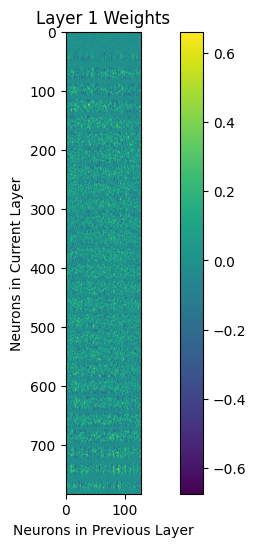

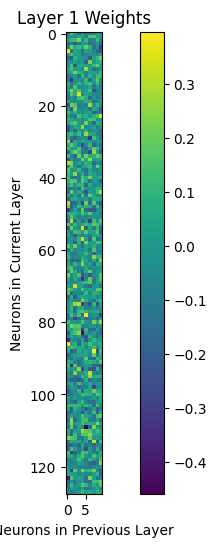

In [44]:
import matplotlib.pyplot as plt

# Function to create and display a heat map
def display_layer_heatmap(model, layer_index):
    # Get the weights of the specified layer
    layer_weights = model.layers[layer_index].get_weights()[0]
    
    # Create a figure for the heat map
    plt.figure(figsize=(10, 6))
    
    # Plot the weights as a heat map
    plt.imshow(layer_weights, cmap='viridis')
    
    # Set labels and title
    plt.xlabel('Neurons in Previous Layer')
    plt.ylabel('Neurons in Current Layer')
    plt.title(f'Layer {layer_index} Weights')
    plt.colorbar()
    
    # Show the plot
    plt.show()

# Display the heat maps for the encoder layer and the classifier layer
display_layer_heatmap(autoencoder, 1)  # Display encoder layer (index 1)
display_layer_heatmap(classifier, 1)   # Display classifier layer (index 1)


### 3. Create a neural network architecture based auto encoder to classification of data. Typically, it consists of an encoder and a decoder. (it contain compilation, training, fitting, predicting) based on the above two points.

In [46]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define the architecture of the autoencoder
input_layer = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_layer)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)


autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))
encoder = Model(input_layer, encoded)

# Define a classifier on top of the encoder
classifier_input = Input(shape=(128,))
classifier_output = Dense(10, activation='softmax')(classifier_input)

classifier = Model(classifier_input, classifier_output)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)
classifier.fit(encoded_train, y_train, epochs=10, batch_size=256, shuffle=True, validation_data=(encoded_test, y_test))

test_loss, test_accuracy = classifier.evaluate(encoded_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

predictions = classifier.predict(encoded_test)


Epoch 1/10
235/235 [==============================] - 2s 8ms/step - loss: 0.2118 - val_loss: 0.1351
Epoch 2/10
235/235 [==============================] - 2s 8ms/step - loss: 0.1185 - val_loss: 0.1035
Epoch 3/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0970 - val_loss: 0.0897
Epoch 4/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0863 - val_loss: 0.0818
Epoch 5/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0801 - val_loss: 0.0772
Epoch 6/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0764 - val_loss: 0.0744
Epoch 7/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0740 - val_loss: 0.0724
Epoch 8/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0723 - val_loss: 0.0710
Epoch 9/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0710 - val_loss: 0.0700
Epoch 10/10
313/313 [==============================] - 0s 1ms/step
Epoch 1/10
235/235 [=========

1/1 [==============================] - 0s 23ms/step


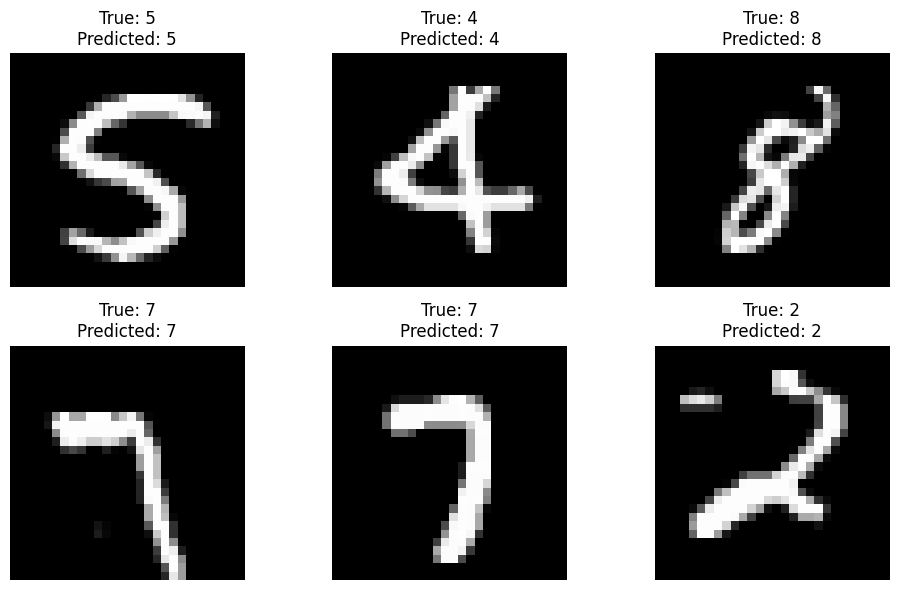

In [47]:
def display_predictions(images, true_labels, predicted_labels):
    plt.figure(figsize=(10, 6))
    for i in range(len(images)):
        plt.subplot(2, len(images)//2, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

random_indices = np.random.randint(0, len(x_test), 6)
sample_images = x_test[random_indices]
true_labels = y_test[random_indices]

# Predict labels using the classifier
predicted_labels = np.argmax(classifier.predict(encoder.predict(sample_images)), axis=1)

display_predictions(sample_images, true_labels, predicted_labels)
